## This program is the main function that runs the simulation such that
1. Compares raw job list with an altered job list. The comparison can be turned off so it only runs on raw job lists. <br>
2. Outputs two csv files for data, one from unaltered job list (called the Benchmark), another from altered joblist (called the Experiment). You can only output csv if you make the Monte-Carlo number of runs = 1 <br>
3. Provides two time series (benchmark and experiment) with time, number of forklifts at different status, number of them waiting on the each dropping off point, and the number of them on all dropping off points together. <br>
4. Provides a visualization. Need some work on this part.

#  <font color=red>READ BEFORE YOU RUN THE CODE </font>
0. Run in Jupyter notebook for best result.
1. You need to run the main function at least once to get updated csv files for data analysis.<br>
2. If you want to test your own joblist optimizing function, change the function <font color=blue>order_tasks(job_list, WAREHOUSE_DIM) </font> at line 108 in the <font color=blue>main() </font> function block.
3. Global variables are in the control panel. Change them if needed. <br>
4. The arrow plotting part needs some better improvements, you can run that but it may not give what you want.<br>
5. There are several black boxes and private functions, private variables in the file. Try not to alter them as it might break the code. <br>

Hansen 07/16/2020 IMA Bootcamp

In [1]:
import itertools
import pandas as pd
import numpy as np
from simulation import Simulation
import matplotlib.pyplot as plt
import ast
import os

# Simulation Part

In [2]:
"""
Control Panel. Change global variables here.
"""
# var 1: order of the forklifts jobs
# var 2: tasks within each job for each forklift
# try to minimize time

WAREHOUSE_DIM = 10  # size of warehouse
N_FORKLIFTS = 30  #number of forklifts available
RECEIVING = [0, 0]  # location of receiving
SHIPPING = [WAREHOUSE_DIM-1, WAREHOUSE_DIM-1]  # location of shipping
LAB = [0, WAREHOUSE_DIM-1]  # location of lab

IF_RUN_EXPERIMENT = True
OUTPUT_TO_CSV = True # whether we want a csv output file 
IF_PRINT = False # if we want the simulation to print how much job is done
N_JOBS = 100 # number of jobs
N_RUNS = 1 # number of runs, for Monte-Carlo purpose

outputfile_bm = 'test_run_bm.csv' # saving the benchmark result
outputfile_ep = 'test_run_ep.csv' # saving the experimental result

if N_RUNS != 1: # if we are actually doing MC then don't output a csv file, to save time
    OUTPUT_TO_CSV = False

In [3]:
def main():
    """
    Runs the Monte-Carlo code, generates total running time in order to
    compare a raw job list with an optimized job list.
    It also saves the running data to a csv file (Can be turned off).
    
    
    Input: nothing
    
    Output: a list of 2 (sub)lists: 
        -The 0th sub-list records the benchmark using a randomly generated joblist
        -The 1st sub_list records the pointwise-optimized joblist
    """
    print("Total number of runs:", N_RUNS)
    print("Total number of jobs for each run:", N_JOBS)
    print("Warehouse dimension is:", WAREHOUSE_DIM)
    print("The number of forklift is:", N_FORKLIFTS)
    print("If running a parallel experiment:", IF_RUN_EXPERIMENT)

    run_time_data = run_simulation(n_runs = N_RUNS,
                                   output_file_bm = outputfile_bm,
                                   output_file_ep = outputfile_ep,
                                   if_run_experiment = IF_RUN_EXPERIMENT,
                                   _if_print = IF_PRINT,
                                   _output_to_csv = OUTPUT_TO_CSV,
                                   _receiving = RECEIVING,
                                   _shipping = SHIPPING,
                                   _lab = LAB,
                                   _warehouse_dim = WAREHOUSE_DIM,
                                   _n_forklifts = N_FORKLIFTS,
                                   _n_jobs = N_JOBS)
    print("Benchmark time for each run: ", run_time_data[0])
    print("Time for each run using optimized list: ", run_time_data[1])
        
    return run_time_data
    
def run_simulation(n_runs,
                   output_file_bm,
                   output_file_ep,
                   if_run_experiment,
                   _if_print,
                   _output_to_csv,
                   _receiving,
                   _shipping,
                   _lab,
                   _warehouse_dim,
                   _n_forklifts, 
                   _n_jobs):
    """
    Black box. Do not alter stuff except for changing the optimized job list.
    """
    Benchmark_time_data = np.zeros(n_runs)
    Experiment_time_data = np.zeros(n_runs)
    for run_number in range(0,n_runs):
        raw_job_list = [generate_random_job(warehouse_dim = _warehouse_dim) for k in range(_n_jobs)]
        """ This boxed part below is the place that you can change"""
        ######### This is where you optimize joblist ##########
        job_list = order_tasks(raw_job_list, _warehouse_dim)
        #######################################################
        
        #Set up the simulation with the RAW joblist
        test_benchmark = Simulation(warehouse_x_dim=_warehouse_dim, 
                          warehouse_y_dim=_warehouse_dim,
                          receiving = _receiving,
                          shipping = _shipping,
                          lab = _lab,
                          n_forklifts=_n_forklifts,
                          forklift_job_lists=raw_job_list, 
                          output_to_csv = False, # boolean
                          if_print = _if_print) # boolean
        Benchmark_time_data[run_number] = test_benchmark.run(output_file_bm)
        
        #Set up the simulation with a CHANGED joblist
        if if_run_experiment == True:
            test_experiment = Simulation(warehouse_x_dim=_warehouse_dim, 
                              warehouse_y_dim=_warehouse_dim,
                              receiving = _receiving,
                              shipping = _shipping,
                              lab = _lab,
                              n_forklifts=_n_forklifts,
                              forklift_job_lists=job_list, 
                              output_to_csv = True,#_output_to_csv, # boolean
                              if_print = _if_print) # boolean
            Experiment_time_data[run_number] = test_experiment.run(output_file_ep)
        
    return [Benchmark_time_data, Experiment_time_data]

def generate_random_job(warehouse_dim = WAREHOUSE_DIM, 
                        receiving = RECEIVING, 
                        shipping = SHIPPING, 
                        lab = LAB):
    """
    This function generates a raw job list randomly, providing the raw_job_list object
    that we need to optimize on. 
    Below is the blackbox that thy shall not touch. 
    """
    job_length = 1 + np.random.randint(3)
    raw_job = np.random.randint(warehouse_dim, size=job_length*2)
    destination = [receiving, shipping, lab][np.random.choice([0,1,2])]
    raw_job = np.append(raw_job, destination)
    raw_job = raw_job.reshape(job_length + 1, 2)
    return raw_job

####################################################################################
####################################################################################
####################################################################################
### Below are the candidates for optimizing the job list ###########################
def order_tasks(job_list, WAREHOUSE_DIM):
    import copy
    """
    This orders the tasks within a certain job to minimize distance
    This does not take into account the original location of the forklift
    NOTE: distance \neq time since time had an error
    """
    
    for i in range(0,len(job_list)): #optimize each job
        job = copy.copy(job_list[i]) #consider a single job
        N_TASKS = len(job)-1 #number of tasks
    
        distance = WAREHOUSE_DIM*len(job)+1 #make this large, this is what we need to beat
        for perm in itertools.permutations(job[:N_TASKS],N_TASKS): #potential permutations
            this_dist = 0 #the distance for this permutation
            for j in range(0,N_TASKS-1):
                this_dist += abs(perm[j][0]-perm[j+1][0]) + abs(perm[j][1]-perm[j+1][1]) #add distance between tasks
            this_dist += abs(perm[N_TASKS-1][0] - job[N_TASKS][0]) + abs(perm[N_TASKS-1][1] - job[N_TASKS][1]) #add distance to delivery point
            
            if this_dist < distance: #better permutation
                distance = this_dist
                job_list[i][0:N_TASKS] = list(perm)
    return job_list

In [4]:
run_time_data = main()

Total number of runs: 1
Total number of jobs for each run: 100
Warehouse dimension is: 10
The number of forklift is: 30
If running a parallel experiment: True
simulation complete, total time =  616
simulation complete, total time =  452
Benchmark time for each run:  [616.]
Time for each run using optimized list:  [452.]


# Data Analysis Part, Need A .csv File to work with

In [5]:
avg = np.average(run_time_data[0])
std = np.std(run_time_data[0])
print("The benchmark average is ", avg, "The benchmark std is ", std)

avg = np.average(run_time_data[1])
std = np.std(run_time_data[1])
print("The experiment average is ", avg, "The experiment std is ", std)

The benchmark average is  616.0 The benchmark std is  0.0
The experiment average is  452.0 The experiment std is  0.0


In [6]:
# load the data, and check if it is successfully loaded
df_bm = pd.read_csv('test_run_bm.csv')
print(df_bm.tail(10))
print(len(df_bm)/N_FORKLIFTS)

df_ep = pd.read_csv('test_run_ep.csv')
print(df_ep.tail(10))
print(len(df_ep)/N_FORKLIFTS)

       time        name current_destination last_loc    status  \
18470   615  Forklift20              [0, 9]   [3, 7]  complete   
18471   615  Forklift21              [0, 0]   [1, 8]  complete   
18472   615  Forklift22              [9, 9]   [7, 1]  complete   
18473   615  Forklift23              [0, 9]   [2, 8]  complete   
18474   615  Forklift24              [9, 9]   [6, 1]  complete   
18475   615  Forklift25              [9, 9]   [8, 1]  complete   
18476   615  Forklift26              [0, 0]   [6, 5]  complete   
18477   615  Forklift27              [9, 9]   [2, 6]  complete   
18478   615  Forklift28              [0, 9]   [0, 8]  complete   
18479   615  Forklift29              [0, 0]   [4, 2]  complete   

       next_update_time  
18470             314.0  
18471             304.0  
18472             287.0  
18473             488.0  
18474             332.0  
18475             334.0  
18476             345.0  
18477             308.0  
18478             307.0  
18479        

In [7]:
"""
Plots a vector field at a given global time spot.
Dot: a forklift's last known position
Arrow: pointing from last position to the next position
Arrow colors: green  - traveling
              grey   - picking
              black  - complete
              red    - waiting
"""

def plot_save_vector_graph(data_frame, if_save_fig = False):
    df = data_frame
    isf = if_save_fig # whether you want figures to save or not
    end_time = df["time"].max()
    for t in range(0,5 + 1):
        plot_given_time(_data_from_feeder = _feeder(_dataframe = df, _target_time = t),
                         if_save_fig = isf)

def plot_given_time(_data_from_feeder, if_save_fig = False):
    # saving figure defalt to false
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    
    _last_loc = _last_loc.values.tolist()
    for i in range(len(_last_loc)):
        _last_loc[i] = _str_to_list(_last_loc[i])
    _last_loc = np.array(_last_loc)
    #print(_last_loc)
    
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    #print(_destination)

    fig = plt.figure(figsize=(15,15))
    plt.ion()
    #plotting the last location
    plt.scatter(_last_loc[:,0],_last_loc[:,1],s=60)
    plt.scatter(_destination[:,0],_destination[:,1],s=60)
    for i in range(len(_destination)):
        plt.arrow(_last_loc[i,0],_last_loc[i,1],
                  _destination[i,0]-_last_loc[i,0],
                  _destination[i,1]-_last_loc[i,1],
                  head_width = 0.1)

    plt.xlim(-2,WAREHOUSE_DIM+1)
    plt.ylim(-2,WAREHOUSE_DIM+1)
    plt.axis('scaled')
    plt.title("Time = %i" %_time)
    if if_save_fig == True:     
        plt.savefig('figures/time%i' %_time + '.png')
        plt.close(fig)
    else:
        plt.draw()
        plt.pause(0.1)
        plt.show()
        
       
    
def _str_to_list(_string):
    res = ast.literal_eval(_string) 
    return res

def _feeder(_dataframe,_target_time):
    df = _dataframe
    # slice the time
    _time = _target_time
    
    subframe = df[df['time'] == _time]
    _last_loc = subframe['last_loc']
    _destination = subframe['current_destination']
    _status = subframe['status']
    _next_update_time = subframe['next_update_time']
    
    return[_time,
           _last_loc, 
           _destination, 
           _status, 
           _next_update_time]


# Time Series Analysis Part, Need A csv File, Need To Run The Previous Code Block

In [8]:
def get_status_data(_data_from_feeder):
    """read from the feeder (at a given time frame), then produces an numpy of 5 components:
clock time, 
number of forklifts waiting, 
number of forklifts traveling,
number of forklifts picking,
number of forklifts completed the work,
number of forklifts waiting for the dropoff points = 
[time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff]
    """
    _time = _data_from_feeder[0]
    _last_loc = _data_from_feeder[1]
    _destination = _data_from_feeder[2]
    _status = _data_from_feeder[3]
    _next_update_time = _data_from_feeder[4]
    _length = len(_status)
    
    time = _time
    n_wait = _status[_status == "waiting"].count()
    n_travel = _status[_status == "traveling"].count()
    n_pick = _status[_status == "picking"].count()
    n_complete = _status[_status == "complete"].count()
    
    # change _destination into a np array for vectorized manipulation
    _destination = _destination.values.tolist()
    for i in range(len(_destination)):
        _destination[i] = _str_to_list(_destination[i])
    _destination = np.array(_destination)
    
    # cast _status into a list _status_list for easier manipulation
    _status_list = _status.values.tolist()
    
    n_wait_dropoff = 0 # initialize to 0
    n_wait_lab = 0
    n_wait_ship = 0
    n_wait_receive = 0
    for i in range(_length):
        if_LAB = (_destination[i][0] == LAB[0] and _destination[i][1] == LAB[1])
        if_SHIPPING = (_destination[i][0] == SHIPPING[0] and _destination[i][1] == SHIPPING[1])
        if_RECEIVING = (_destination[i][0] == RECEIVING[0] and _destination[i][1] == RECEIVING[1])
        if if_LAB+if_SHIPPING+if_RECEIVING == True: #either shipping, receiving or lab
            if _status_list[i] == 'waiting':
                n_wait_dropoff += 1
                if if_LAB == True:
                    n_wait_lab += 1
                if if_SHIPPING == True:
                    n_wait_ship += 1
                if if_RECEIVING == True:
                    n_wait_receive += 1
                
    return [time, 
            n_wait, 
            n_travel, 
            n_pick, 
            n_complete, 
            n_wait_dropoff, 
            n_wait_lab, 
            n_wait_ship, 
            n_wait_receive]

#    print(time, n_wait, n_travel, n_pick, n_complete, n_wait_dropoff)
 #   print(_destination, type(_destination))
#    print(_status_list, type(_status_list))

df_bm = pd.read_csv('test_run_bm.csv')
print(df_bm.head(10))
print(len(df_bm)/N_FORKLIFTS)

time_series_data_bm = np.empty([df_bm["time"].max()+1,9])
time_series_data_bm[-1][:] = [df_bm["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_bm["time"].max()):
    time_series_data_bm[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_bm, _target_time = i))
    
df_ep = pd.read_csv('test_run_ep.csv')
print(df_ep.head(10))
print(len(df_ep)/N_FORKLIFTS)

time_series_data_ep = np.empty([df_ep["time"].max()+1,9])
time_series_data_ep[-1][:] = [df_ep["time"].max()+1, 0,0,0,N_FORKLIFTS,0,0,0,0]
            
for i in range(0,df_ep["time"].max()):
    time_series_data_ep[i][:] = \
    get_status_data(_data_from_feeder = _feeder(_dataframe = df_ep, _target_time = i))

   time       name current_destination last_loc     status  next_update_time
0     0  Forklift0              [6, 2]   [0, 0]  traveling              12.0
1     0  Forklift1              [4, 5]   [0, 0]  traveling              10.0
2     0  Forklift2              [4, 2]   [0, 0]  traveling               7.0
3     0  Forklift3              [4, 5]   [0, 0]  traveling              10.0
4     0  Forklift4              [3, 4]   [0, 0]  traveling               8.0
5     0  Forklift5              [2, 7]   [0, 0]  traveling               6.0
6     0  Forklift6              [8, 5]   [0, 0]  traveling              13.0
7     0  Forklift7              [8, 0]   [0, 0]  traveling               7.0
8     0  Forklift8              [6, 8]   [0, 0]  traveling              14.0
9     0  Forklift9              [5, 1]   [0, 0]  traveling               6.0
616.0
   time       name current_destination last_loc     status  next_update_time
0     0  Forklift0              [6, 2]   [0, 0]  traveling            

# Plotting the time series from a specific csv file

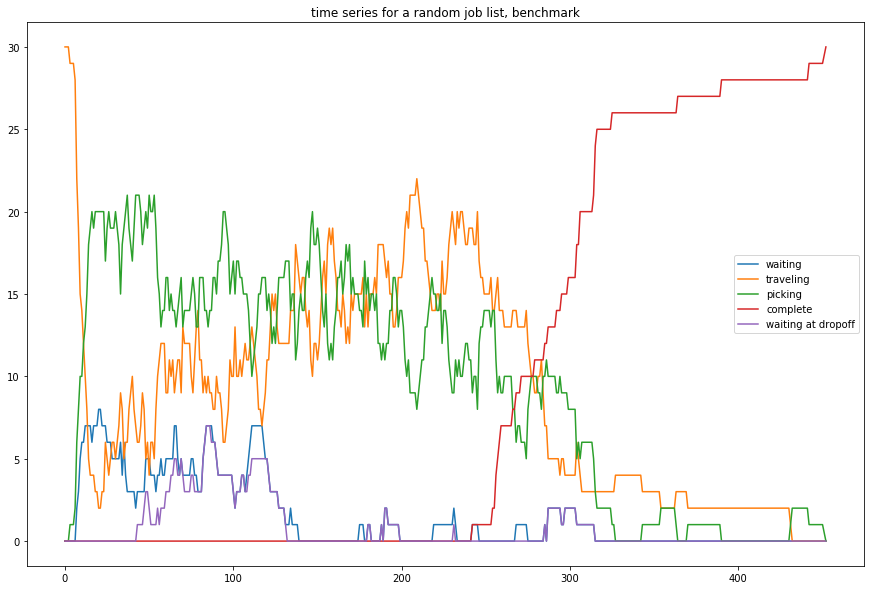

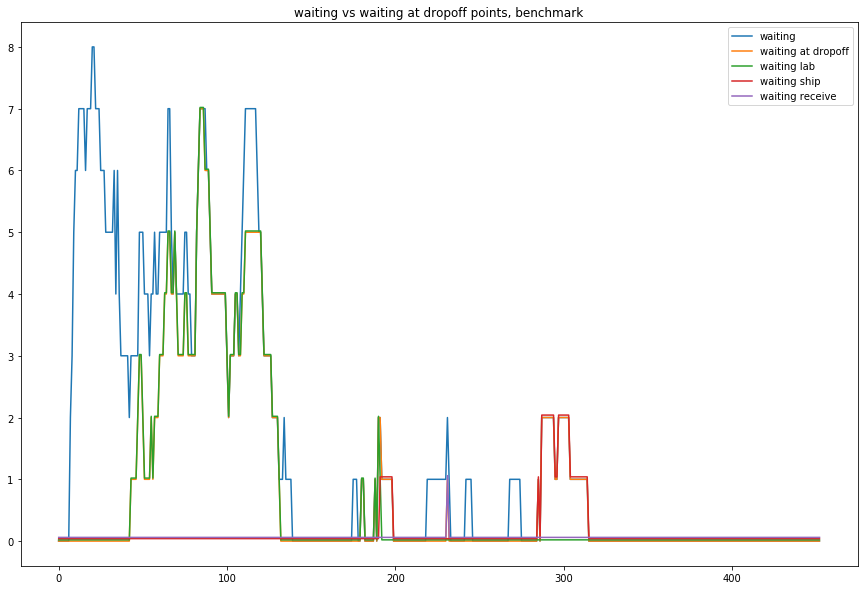

In [12]:
"""
Plotting for the benchmark
"""
ts1 = time_series_data_ep
labels = ['waiting', 'traveling', 'picking', 'complete', 'waiting at dropoff']
plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1])
plt.plot(ts1[:,0],ts1[:,2])
plt.plot(ts1[:,0],ts1[:,3])
plt.plot(ts1[:,0],ts1[:,4])
plt.plot(ts1[:,0],ts1[:,5])
plt.title('time series for a random job list, benchmark.')
plt.legend(labels)
plt.show()

labels = ['waiting', 'waiting at dropoff', 'waiting lab','waiting ship','waiting receive']
plt.figure(figsize=(15,10))
plt.plot(ts1[:,0],ts1[:,1])
plt.plot(ts1[:,0],ts1[:,5])
plt.plot(ts1[:,0]+0.02,ts1[:,6]+0.02)
plt.plot(ts1[:,0]+0.04,ts1[:,7]+0.04)
plt.plot(ts1[:,0]+0.06,ts1[:,8]+0.06)
plt.title('waiting vs waiting at dropoff points, benchmark')
plt.legend(labels)
plt.show()

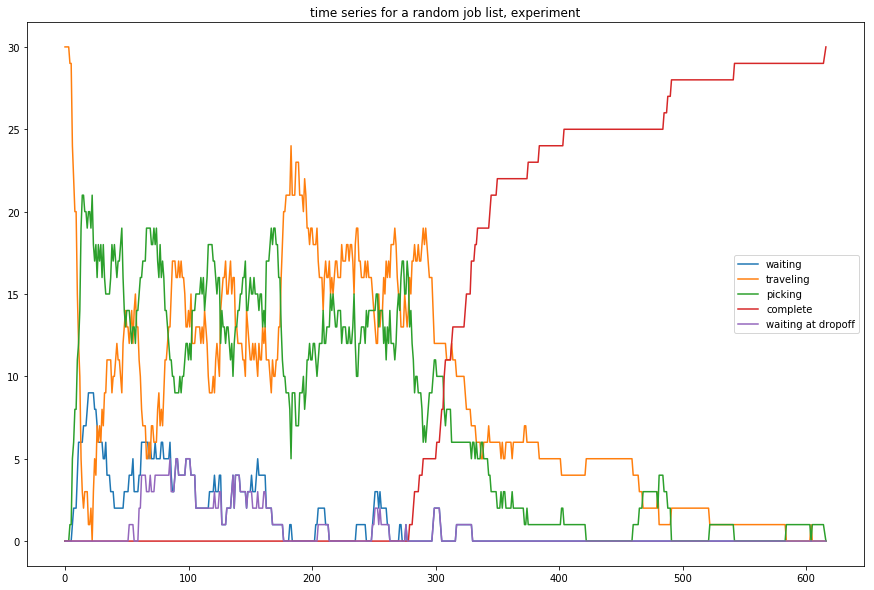

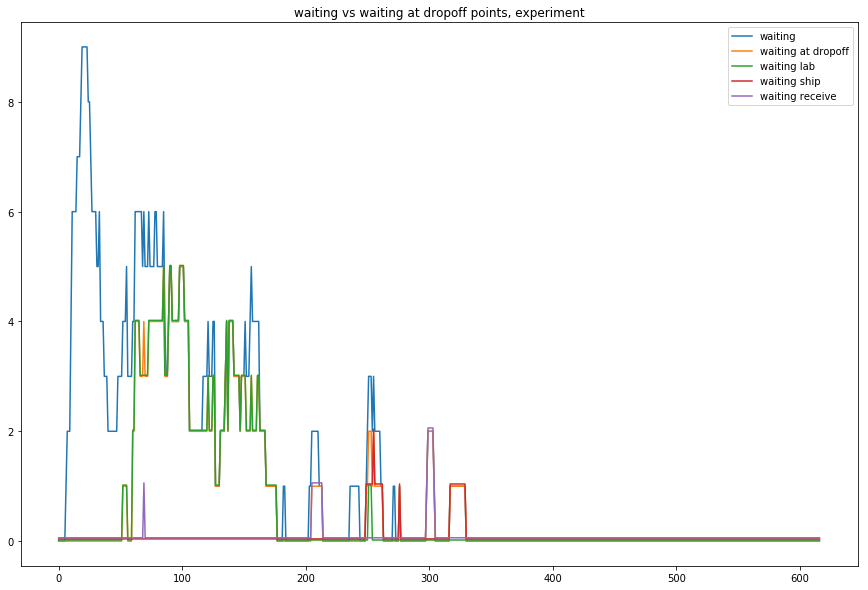

In [13]:
"""
Plotting for the experiment
"""
ts2 = time_series_data_bm
labels = ['waiting', 'traveling', 'picking', 'complete', 'waiting at dropoff']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1])
plt.plot(ts2[:,0],ts2[:,2])
plt.plot(ts2[:,0],ts2[:,3])
plt.plot(ts2[:,0],ts2[:,4])
plt.plot(ts2[:,0],ts2[:,5])
plt.title('time series for a random job list, experiment')
plt.legend(labels)
plt.show()

labels = ['waiting', 'waiting at dropoff', 'waiting lab','waiting ship','waiting receive']
plt.figure(figsize=(15,10))
plt.plot(ts2[:,0],ts2[:,1])
plt.plot(ts2[:,0],ts2[:,5])
plt.plot(ts2[:,0]+0.02,ts2[:,6]+0.02)
plt.plot(ts2[:,0]+0.04,ts2[:,7]+0.04)
plt.plot(ts2[:,0]+0.06,ts2[:,8]+0.06)
plt.title('waiting vs waiting at dropoff points, experiment')
plt.legend(labels)
plt.show()

# Arrow Plot

In [ ]:
plot_save_vector_graph(data_frame = df, if_save_fig = False)

# Crap underneath is irrevelant scratch paper stuff